<p align="center">
   <img src="spark-ml.png">
</p>

## SparkML
In this notebook, we'll use Spark for:

* Sentiment Analysis
* Natural Language Processing (NLP)
* Decision Trees

We will be using a dataset of roughly 50,000 IMDB reviews, which includes the English language text of that review and the rating associated with it (1-10). Based on the text of the review, we want to predict if the rating is "positive" or "negative".

### 1. Load libraries and foundry utilities

In [2]:
import pyspark
from pyspark.sql import SparkSession


# Pandas
import pandas as pd

# Plot
%matplotlib inline
import matplotlib.pyplot as plt

# Foundry
import foundrywrapper
from foundrywrapper import FoundryWrapper

In [3]:
#Required for foundry, not useful for spark purposes
fw = FoundryWrapper()
fw

Foundry-Wrapper v0.3.3
Welcome JEREMY PIRARD (PIRARD_J)

In [4]:
spark = (SparkSession.builder 
        .master('spark://spark-master:7077') #master node URL
        .appName('~ Spark hands-on: Spark-ML ~') #my App name
        .config('spark.driver.memory', '1g') # memory allocated to the master
        .config('spark.driver.cores', '2') # CPU's allocated to the master
        .config('spark.executor.instances', '2') # how many executors
        .config('spark.executor.memory', '4g') # memory per executor (where the data is stored)
        .config('spark.executor.cores', '2') #CPU's per executor
        .config(conf=fw.spark.get_spark_app_config())
        .getOrCreate())


In [5]:
#Foundry stuff
file_rid = fw.compass.get_rid('/Airbus/EY - Zero AOG/ATARI/Spark Hands-on/IMDB_reviews')
fw.catalog.get_dataset_view_stats(file_rid)

{'sizeInBytes': 65834871, 'numFiles': 1, 'hiddenFilesSizeInBytes': 0, 'numHiddenFiles': 0, 'numTransactions': 1}

In [6]:
reviewsDF = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(fw.spark.foundryfs_uri(file_rid))

### 2. Basic exploration

The dataset is a toy one and not that large, let's register it into a SQL view.

In [7]:
reviewsDF.createOrReplaceTempView("reviews")

In [8]:
reviewsDF.printSchema()

root
 |-- review: string (nullable = true)
 |-- rating: double (nullable = true)



In [9]:
reviewsDF.show()

+--------------------+------+
|              review|rating|
+--------------------+------+
|It's hard to imag...|   9.0|
|Two of Hollywood'...|  10.0|
|I saw this film w...|   3.0|
|you have loved Th...|  10.0|
|I hated the way M...|   1.0|
|The first and onl...|  10.0|
|This movie is tol...|   4.0|
|Unfortunately, th...|   1.0|
|I hope we never b...|  10.0|
|I managed to tape...|  10.0|
|for a lot of time...|   4.0|
|This is a delirio...|   7.0|
|This is an 'antho...|   4.0|
|This is just what...|   1.0|
|** out of **** st...|   4.0|
|A dying Kung Fu m...|   7.0|
|An uptight voyeur...|   4.0|
|Being a freshman ...|   9.0|
|Lensman is a rath...|   8.0|
|Quite what the pr...|   2.0|
+--------------------+------+
only showing top 20 rows



We only have two columns, the target that we will predict (*rating*) and the review column which is text data. To create a predictive model we will need to create some variables out of this text.

What does a review look like ?

In [10]:
reviewsDF.take(1) # Recall this is an action

[Row(review="It's hard to imagine a director capable of such godawful crap as 'Notting Hill' pulling off something as sensitive and as attractive as this, but well, here's the evidence and it's quite compelling. Several have alluded to TV drama, and yes, this does have a seventies Play for Today feel at times, but is always a cut above, mainly I think owing to some quite superlative acting from Anne Reid and to a fine script which shadow-boxes with cliché without ever getting one on the nose, except maybe right at the end. (I didn't like either the tracking shot of indifferent goodbyes through the hallway, nor the oh-what-a-beautiful-morning final scene: she deserved a more studied finale than that I think, after all that hard work. The slippers business was a bit OTT too, on reflection).<br /><br />What I mean about avoiding cliché: well, I for one had a sinking expectation that the 'mature' man May's daughter tries to set her up with would be cast in 2 dimensions as a repulsive old b

What does the distribution of scores look like?

In [11]:
spark.sql("SELECT count(rating) , rating  FROM reviews GROUP BY rating ORDER BY rating").show()

+-------------+------+
|count(rating)|rating|
+-------------+------+
|        10120|   1.0|
|         4586|   2.0|
|         4961|   3.0|
|         5331|   4.0|
|         4802|   7.0|
|         5858|   8.0|
|         4606|   9.0|
|         9730|  10.0|
+-------------+------+



Is the same as :

In [12]:
from  pyspark.sql.functions import *
reviewsDF.select("rating", "rating").groupBy("rating").agg(count("rating")).orderBy("rating").show()


+------+-------------+
|rating|count(rating)|
+------+-------------+
|   1.0|        10120|
|   2.0|         4586|
|   3.0|         4961|
|   4.0|         5331|
|   7.0|         4802|
|   8.0|         5858|
|   9.0|         4606|
|  10.0|         9730|
+------+-------------+



The authors of this dataset have removed the "neutral" ratings, which they defined as a rating of 5 or 6.

## 2. Machine learning workflow using Spark-ML

Spark ML is a set of API built on top of DataFrame to provide ML worklfows. It is insipred from scikit-learn library in regular python. It has 3 main concepts:
- **Transformers**: Algorithm that transforms a DataFrame into another DataFrame (used for features engineering);
- **Estimator**: Algorithm fitted on a DataFrame and producing a Transformer;
- **Pipeline**: Chains multiple Transformers and Estimators to create an ML workflow.


See [the documentation](https://spark.apache.org/docs/latest/api/python/index.html) to have a comprehensive list of the features from Spark ML.

On the schema below, we can see an example of a machine learning workflow illustrating these concepts:

<img src="nlp_ml_workflow2.png">

### 2.1 Train Test Split

We'll split our data into training and test samples. We will use 80% for training, and the remaining 20% for testing. We set a seed to reproduce the same results (i.e. if you re-run this notebook, you'll get the same results both times).

In [13]:
(trainDF, testDF) = reviewsDF.randomSplit([0.8, 0.2], seed=42)
trainDF.cache() # caching it since it will be used for many feature generation
testDF.cache() # Same reason

DataFrame[review: string, rating: double]

Let's determine our baseline accuracy

In [14]:
positiveRatings = trainDF.filter("rating >= 5").count()
totalRatings = trainDF.count()

print("Baseline accuracy: {0:.2f}%".format(positiveRatings/totalRatings*100))

Baseline accuracy: 49.96%


## 2.2 Generating Transformers and Estimators

This is the feature engineering of our model!
We will create:
- A RegexTokenizer (split a sentence into list of word): transformer
- A StopWordsRemover (remove common words ("I", "the" ...): transformer
- A CountVectorize (counts the frequency of each word in a sentence): estimator -> it does not return a DataFrame but features!
- A Binarizer (to predict only two class "negative sentiment" and "positive" sentiment): transformer
- A DecisionTreeClassifier, that will use the features from the CountVectorizer to make a prediction: estimator

Everything will be wrapped up into a Pipeline object (estimator). When fitted, it will produce a transformer. We will then apply it to the test DataFrame to create a new column corresponding to the prediction of the DecisionTreeClassifier !

*Nota*: The quality of the feature engineering is not the purpose of the notebook. we could have used TF_IDF or a better algorithm for getting a better score. Cross-validation and hyperparameter tuning are not covered here but are available in Spark ML (*cf docs*).

Tokenizer: Splitting each sentence into individual term.
See https://spark.apache.org/docs/2.2.0/ml-features.html#tokenizer
You can use this to remove non alphanumeric characters (commas, dots ...) and to lowercase every word in order to facilitate processing.

In [15]:
from pyspark.ml.feature import RegexTokenizer

tokenizer = (RegexTokenizer()
            .setInputCol("review")
            .setOutputCol("tokens")
            .setPattern("\\W+"))

tokenizedDF = tokenizer.transform(reviewsDF)
tokenizedDF.limit(5).show() # Look at a few tokenized reviews

+--------------------+------+--------------------+
|              review|rating|              tokens|
+--------------------+------+--------------------+
|Irwin Allen was g...|   4.0|[irwin, allen, wa...|
|I got seriously r...|   1.0|[i, got, seriousl...|
|The basic idea be...|   2.0|[the, basic, idea...|
|I always tell peo...|  10.0|[i, always, tell,...|
|I'm an admirer of...|   8.0|[i, m, an, admire...|
+--------------------+------+--------------------+



There are a lot of words that do not contain much information about the sentiment of the review (e.g. `the`, `a`, etc.). Let's remove these uninformative words using `StopWordsRemover`.

In [16]:
from pyspark.ml.feature import StopWordsRemover

remover = (StopWordsRemover()
          .setInputCol("tokens")
          .setOutputCol("stopWordFree"))

removedStopWordsDF = remover.transform(tokenizedDF)
removedStopWordsDF.limit(5).show() # Look at a few tokenized reviews without stop words

+--------------------+------+--------------------+--------------------+
|              review|rating|              tokens|        stopWordFree|
+--------------------+------+--------------------+--------------------+
|It's hard to imag...|   9.0|[it, s, hard, to,...|[hard, imagine, d...|
|Two of Hollywood'...|  10.0|[two, of, hollywo...|[two, hollywood, ...|
|I saw this film w...|   3.0|[i, saw, this, fi...|[saw, film, franc...|
|you have loved Th...|  10.0|[you, have, loved...|[loved, shawshank...|
|I hated the way M...|   1.0|[i, hated, the, w...|[hated, way, ms, ...|
+--------------------+------+--------------------+--------------------+



Where do the stop words actually come from? Spark includes a small English list as a default, which we're implicitly using here.

In [17]:
stopWords = remover.getStopWords()
stopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

Let's remove the `br` from our reviews.

In [18]:
remover.setStopWords(["br"] + stopWords)
removedStopWordsDF = remover.transform(tokenizedDF)

Let's apply a CountVectorizer model

This model maps each sentence to a matrix containing each count of the words defined by the whole vocabulary of the corpus.

For instance

 id | texts
----|----------
 0  | Array("a", "b", "c")
 1  | Array("a", "b", "b", "c", "a")
 
 maps to:
 
  id | texts                           | vector
----|---------------------------------|---------------
 0  | Array("a", "b", "c")            | (3,[0,1,2],[1.0,1.0,1.0])
 1  | Array("a", "b", "b", "c", "a")  | (3,[0,1,2],[2.0,2.0,1.0])
 
 This means that there are two times the word "a" , "b" and one time the word "c" in the second sentence.
 
 This produces a good representation to feed a classification algorithm.
 
 Nota: Setting the vocabulary size forces the model to select the most frequent words in the given corpus. This reduce the dimension of the features engineered data.
 

In [19]:
from pyspark.ml.feature import CountVectorizer

counts = (CountVectorizer()
          .setInputCol("stopWordFree")
          .setOutputCol("features")
          .setVocabSize(1000))

countModel = counts.fit(removedStopWordsDF) # It's a model

__Now let's adjust the label (target) values__

We want to group the reviews into "positive" or "negative" sentiment. So all of the star "levels" need to be collapsed into one of two groups.

In [20]:
from pyspark.ml.feature import Binarizer

binarizer = (Binarizer()
            .setInputCol("rating")
            .setOutputCol("label")
            .setThreshold(5.0))

Now we are going to use a Decision Tree model to fit to our dataset.

In [21]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

dtc = DecisionTreeClassifier()

pipeline = Pipeline().setStages([tokenizer, remover, counts, binarizer, dtc])

In [22]:
pipelineModel = pipeline.fit(trainDF)
decisionTree = pipelineModel.stages[-1] #We can retrieve a particular step of our pipeline like this

In [23]:
print(decisionTree.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_2d7d2f1857bc) of depth 5 with 55 nodes
  If (feature 13 <= 0.5)
   If (feature 141 <= 0.5)
    If (feature 341 <= 0.5)
     If (feature 15 <= 0.5)
      If (feature 262 <= 0.5)
       Predict: 1.0
      Else (feature 262 > 0.5)
       Predict: 0.0
     Else (feature 15 > 0.5)
      If (feature 262 <= 0.5)
       Predict: 1.0
      Else (feature 262 > 0.5)
       Predict: 0.0
    Else (feature 341 > 0.5)
     If (feature 782 <= 1.5)
      If (feature 634 <= 1.5)
       Predict: 0.0
      Else (feature 634 > 1.5)
       Predict: 1.0
     Else (feature 782 > 1.5)
      Predict: 1.0
   Else (feature 141 > 0.5)
    If (feature 35 <= 0.5)
     If (feature 39 <= 0.5)
      Predict: 0.0
     Else (feature 39 > 0.5)
      If (feature 32 <= 3.5)
       Predict: 0.0
      Else (feature 32 > 3.5)
       Predict: 1.0
    Else (feature 35 > 0.5)
     If (feature 191 <= 1.5)
      Predict: 0.0
     Else (feature 191 > 1.5)
      If (feature 

Let's save the pipeline model.

In [24]:
# Need to add foundry stuff

# fileName = "/tmp/DT_Pipeline"
# pipelineModel.write().overwrite().save(fileName)

In [25]:
# from pyspark.ml import PipelineModel
# # Load saved model
# savedPipelineModel = PipelineModel.load(fileName)

In [26]:
# resultDF = savedPipelineModel.transform(testDF)

### 2.3 Evaluating the model

Recall a prediction of 1 (resp. 0) maps to a positive (resp. negative) sentiment (rating > 5 or rating < 5).

In [27]:
resultDF = pipelineModel.transform(testDF)
resultDF.show()

+--------------------+------+--------------------+--------------------+--------------------+-----+----------------+--------------------+----------+
|              review|rating|              tokens|        stopWordFree|            features|label|   rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+--------------------+-----+----------------+--------------------+----------+
|!!!! MILD SPOILER...|   4.0|[mild, spoilers, ...|[mild, spoilers, ...|(1000,[0,3,4,7,11...|  0.0|[7987.0,11496.0]|[0.40994713339834...|       1.0|
|!!!! MILD SPOILER...|   4.0|[mild, spoilers, ...|[mild, spoilers, ...|(1000,[0,1,2,3,4,...|  0.0| [4419.0,1247.0]|[0.77991528415107...|       0.0|
|!!!!! OF COURSE T...|   4.0|[of, course, ther...|[course, spoilers...|(1000,[1,2,9,11,1...|  0.0| [4419.0,1247.0]|[0.77991528415107...|       0.0|
|'2001: A Space Od...|   7.0|[2001, a, space, ...|[2001, space, ody...|(1000,[1,2,3,5,6,...|  1.0|[7987.0,11496.

See accuracy of the model on the test set

In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Accuracy: %(result)s" % {"result": evaluator.evaluate(resultDF)})

Accuracy: 0.696548948586377


Even if there is a lot of work to do we have improved the accuracy of the model comparing to a baseline ! This could be enhanced by tuning parameter of the model, adding more complex natural language processing features such as [TF-IDF](https://spark.apache.org/docs/2.2.0/ml-features.html#tf-idf), using a larger vocabulary, using n-grams ...

See the confusion matrix

In [29]:
resultDF.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 4380|
|  0.0|       1.0| 2413|
|  1.0|       0.0|  603|
|  0.0|       0.0| 2543|
+-----+----------+-----+



## Appendix: Go back to regular python code to generate visualization

Let's plot a nicer view of our confusion matrix using regular python/pandas/sklearn librairies.

Taken from: https://runawayhorse001.github.io/LearningApacheSpark/classification.html

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
resultDF.take(1)

[Row(review='!!!! MILD SPOILERS !!!!<br /><br />The premise goes like this : A store gets burnt down and assistant Sergio is asked by the father of the man who started the fire to take the wrap to which Sergio agrees .<br /><br />So far so good , but there`s a fair lapse of logic involved Sergio agrees to do this for the sum of 25,000 dollars but why ? Come on guys if you were a good looking white boy would you run the risk of getting a long spell in a tough jail ( A very real possibilty for arson ) for the sake of 25 grand ? I know I wouldn`t , and seeing as you`d have a criminal record no employer would want to touch you with a barge pole so is $25,000 dollars all that much for a life of workfare and welfare cheques ? There`s also something else that seems to have gone without notice from the premise , since Mister Lumpke has told Sergio that his son did the fire he seems unware of the possibility that he may know too much . Wouldn`t alarm bells be ringing in your mind about someone 

In [32]:
import pandas
class_temp = resultDF.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()

class_names = class_temp["label"].values.tolist()

In [33]:
from sklearn.metrics import confusion_matrix
y_true = resultDF.select("label")
y_true = y_true.toPandas()

y_pred = resultDF.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[4380,  603],
       [2413, 2543]])

Confusion matrix, without normalization
[[4380  603]
 [2413 2543]]


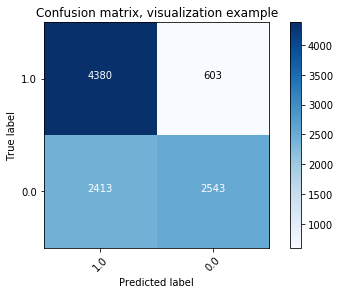

In [34]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, visualization example')
plt.show()

In [35]:
spark.stop()